In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
#setup API key
import os
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")

In [3]:
#Setting up the environmet key
os.environ["OPENAI_API_KEY"]=OPENAI_API_KEY

In [19]:
#Lets import the required libraries
import pandas as pd
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict, List   #
from langchain_core.tools import tool    #for creating Tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver   #To sustain the memory
from langgraph.prebuilt import ToolNode     #To create the Nodes for Tool

In [7]:
# Load the Groq chat model
from langchain_groq import ChatGroq
openai_model = ChatGroq(
    groq_api_key="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",  # Set your API key here or use env variable
    model_name="gemma2-9b-it",   # Groq's most capable model
)

In [45]:
#Load the model
from langchain_openai import ChatOpenAI
openai_model=ChatOpenAI(model="gpt-4o")

In [48]:
openai_model.invoke('Hi, My Name is Yaseen')

AIMessage(content='Hello Yaseen! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 15, 'total_tokens': 27, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'id': 'chatcmpl-BbvSOehQ3tbDfTs4qQRze3TM7tTDQ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--308db098-a14c-4e7c-9e67-8de6ff51780a-0', usage_metadata={'input_tokens': 15, 'output_tokens': 12, 'total_tokens': 27, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [12]:
#We have our model ready, now lets create a Tool

In [49]:
#Load meeting data
@tool
def load_meeting_data() -> List[TypedDict]:
    """Tool to load meeting data from a CSV file."""
    df = pd.read_csv("yaseen_khan_missed_meetings_2.csv")
    meetings = df.to_dict(orient="records")
    return meetings

In [95]:
def load_meeting_data() -> List[TypedDict]:
    """Tool to load meeting data from a CSV file."""
    df = pd.read_csv("yaseen_khan_missed_meetings_2.csv")
    meetings = df.to_dict(orient="records")
    return meetings

In [106]:
data=load_meeting_data()
for i in data:
    print(i)

{'Meeting_ID': 'MTG0001', 'Title': 'Whiteboard Web-Enabled Roi', 'Date_Time': '4/27/2025 12:00', 'Duration': 15, 'Attendees': 'Yaseen Khan, Lauren Raymond, James Mccoy, Mrs. Amanda Barron, Kelsey Clayton, Jose Parker, Sarah Hall', 'Organizer': 'Tim Brown', 'Location/Link': 'Microsoft Teams', 'Meeting Type': 'Retrospective', 'Missed by User': True, 'Has MOM': True, 'Has Transcript': False, 'MOM Content': 'Meeting Summary:\nThe team reviewed the quarterly sales performance and discussed areas for improvement.\n\nAction Items:\n- Prepare detailed analytics report.\n- Escalate unresolved issues to the IT support.\n- Arrange a session on data compliance practices.', 'Transcript Content': nan, 'Recommended Action': nan}
{'Meeting_ID': 'MTG0002', 'Title': 'Deliver Frictionless E-Markets', 'Date_Time': '4/29/2025 15:00', 'Duration': 30, 'Attendees': 'Yaseen Khan, April Hancock, Meghan Mckinney, Ricardo Cole', 'Organizer': 'George Hawkins', 'Location/Link': 'Zoom', 'Meeting Type': 'Team Sync', 

In [109]:
data

[{'Meeting_ID': 'MTG0001',
  'Title': 'Whiteboard Web-Enabled Roi',
  'Date_Time': '4/27/2025 12:00',
  'Duration': 15,
  'Attendees': 'Yaseen Khan, Lauren Raymond, James Mccoy, Mrs. Amanda Barron, Kelsey Clayton, Jose Parker, Sarah Hall',
  'Organizer': 'Tim Brown',
  'Location/Link': 'Microsoft Teams',
  'Meeting Type': 'Retrospective',
  'Missed by User': True,
  'Has MOM': True,
  'Has Transcript': False,
  'MOM Content': 'Meeting Summary:\nThe team reviewed the quarterly sales performance and discussed areas for improvement.\n\nAction Items:\n- Prepare detailed analytics report.\n- Escalate unresolved issues to the IT support.\n- Arrange a session on data compliance practices.',
  'Transcript Content': nan,
  'Recommended Action': nan},
 {'Meeting_ID': 'MTG0002',
  'Title': 'Deliver Frictionless E-Markets',
  'Date_Time': '4/29/2025 15:00',
  'Duration': 30,
  'Attendees': 'Yaseen Khan, April Hancock, Meghan Mckinney, Ricardo Cole',
  'Organizer': 'George Hawkins',
  'Location/Lin

In [133]:
#@tool
def analyze_meeting(meeting: TypedDict) -> str:
    """Analyzes MoM or Transcript from a meeting and returns a summary."""
    mom = meeting.get("MOMContent")
    print("Analyzing meeting:", mom)

In [134]:
analyze_meeting(data[1])

Analyzing meeting: None


In [143]:
def analyze_meeting(meeting: dict) -> str:
    """Analyzes MoM or Transcript from a meeting and returns a summary."""
    
    # Try to extract the 'MoM' content (Minutes of Meeting)
    mom = meeting.get("MOM Content", "")
    
    # Try to extract the 'Transcript' content
    transcript = meeting.get("Transcript Content", "")

    # Decide what content to use: MoM gets priority, else use transcript
    if mom:
        content = f"MoM:\n{mom}"
    elif transcript:
        content = f"Transcript:\n{transcript}"
    else:
        return "No MoM or Transcript available."  # If both are missing, return a message

    # Construct a prompt to ask the LLM to summarize and suggest actions
    prompt = f"""
    You're an AI assistant for Yaseen Khan, responsible for analyzing meeting content which he was missed during his leave.
    Your task is to read the content of the meeting, analyse and recommend actions such as tasks to complete, follow-up meetings to schedule, or status updates to provide

    {content}
    """

    # Call the chat model (e.g. OpenAI/Groq) with the prompt
    response = openai_model.invoke(prompt)
    
    # Return the textual response from the model
    return response.content

In [144]:
for i in range(1, 7):
    print(analyze_meeting(data[i]))

Based on the meeting content, here are my recommendations for Yaseen Khan:

1. **Escalate Unresolved Issues to IT Support:**
   - Action: Contact the IT support team to discuss any unresolved technical issues related to the product launch. Ensure that these issues are clearly documented and escalate them for quick resolution to avoid any potential delays in the launch.

2. **Validate Changes with the QA Team:**
   - Action: Coordinate with the QA (Quality Assurance) team to ensure that any recent changes in the product or marketing strategy have been thoroughly reviewed and validated. Schedule a review session if necessary to go over the changes and confirm that they meet quality standards.

3. **Update the Project Plan with New Timelines:**
   - Action: Review the updated marketing strategies and reflect these changes in the project plan. Adjust timelines as necessary to align with the finalized strategies and ensure all stakeholders are informed of the updated schedule.

4. **Follow-

In [145]:
def analyze_meetings_batch(meetings: list[dict]) -> list[str]:
    """Analyzes multiple meetings and returns summaries for each."""
    
    results = []

    for i, meeting in enumerate(meetings, 1):
        mom = meeting.get("MOM Content", "")
        transcript = meeting.get("Transcript Content", "")

        if mom:
            content = f"MoM:\n{mom}"
        elif transcript:
            content = f"Transcript:\n{transcript}"
        else:
            results.append(f"Meeting {i}: No MoM or Transcript available.")
            continue

        prompt = f"""
        You're an AI assistant for Yaseen Khan, responsible for analyzing meeting content which he missed during his leave.
        Your task is to read the content of the meeting, analyze it, and recommend actions such as tasks to complete, follow-up meetings to schedule, or status updates to provide.

        Meeting {i} content:
        {content}
        """

        # Call the LLM model
        response = openai_model.invoke(prompt)

        # Append the result for this meeting
        results.append(f"Meeting {i} Summary:\n{response.content.strip()}")

    return results


In [150]:
df=data[:5]
summaries = analyze_meetings_batch(df)
print(summaries)


["Meeting 1 Summary:\nBased on the meeting content, here are the recommended actions for Yaseen Khan:\n\n1. **Prepare Detailed Analytics Report:**\n   - Action: Work with the sales and analytics teams to gather data and insights.\n   - Deadline: Establish a timeline to complete the report, ensuring it aligns with the team's next review meeting.\n   - Consider assigning specific sections of the report to team members with relevant expertise.\n\n2. **Escalate Unresolved Issues to IT Support:**\n   - Action: Identify the unresolved issues discussed in the meeting.\n   - Steps: Provide a clear description of each issue, potential impacts, and any troubleshooting attempts made.\n   - Communication: Contact the IT support team and schedule a meeting or a call to discuss the issues in detail.\n\n3. **Arrange a Session on Data Compliance Practices:**\n   - Action: Organize a training session or workshop focused on data compliance for the team.\n   - Speaker/Trainer: Find an expert or engage wi

In [151]:
for summary in summaries:
    print(summary)
    print("=" * 80)

Meeting 1 Summary:
Based on the meeting content, here are the recommended actions for Yaseen Khan:

1. **Prepare Detailed Analytics Report:**
   - Action: Work with the sales and analytics teams to gather data and insights.
   - Deadline: Establish a timeline to complete the report, ensuring it aligns with the team's next review meeting.
   - Consider assigning specific sections of the report to team members with relevant expertise.

2. **Escalate Unresolved Issues to IT Support:**
   - Action: Identify the unresolved issues discussed in the meeting.
   - Steps: Provide a clear description of each issue, potential impacts, and any troubleshooting attempts made.
   - Communication: Contact the IT support team and schedule a meeting or a call to discuss the issues in detail.

3. **Arrange a Session on Data Compliance Practices:**
   - Action: Organize a training session or workshop focused on data compliance for the team.
   - Speaker/Trainer: Find an expert or engage with internal compl

In [153]:
class AgentState(TypedDict):
    meetings: list[dict]  # <- This will store the output of load_meeting_data

In [1]:
def analyze_meetings_batch(state: AgentState) -> dict:
    """Analyzes multiple meetings and returns summaries for each."""
    meetings = state.get("meetings", [])
    results = []

    for i, meeting in enumerate(meetings, 1):
        print(f"Analyzing meeting {i}...")
        mom = meeting.get("MOM Content", "")
        transcript = meeting.get("Transcript Content", "")

        if mom:
            content = f"MoM:\n{mom}"
        elif transcript:
            content = f"Transcript:\n{transcript}"
        else:
            results.append(f"Meeting {i}: No MoM or Transcript available.")
            continue

        prompt = f"""
        You're an AI assistant of User, responsible for analyzing meeting content which he missed during his leave.
        Your task is to read the content of the meeting, analyze it, and recommend actions such as tasks to complete, follow-up meetings to schedule, or status updates to provide.

        Meeting {i} content:
        {content}
        """
        response = openai_model.invoke(prompt)
        results.append(f"Meeting {i} Summary:\n{response.content.strip()}")

    return {"analysis": results}


NameError: name 'AgentState' is not defined

In [155]:
df=data[:5]
summaries = analyze_meetings_batch({"meetings": df})
print(summaries)

{'analysis': ["Meeting 1 Summary:\nBased on the content of Meeting 1, here’s a breakdown of recommended actions:\n\n1. **Action Items to Complete**:\n   - **Prepare Detailed Analytics Report**: You or a designated team member should work on compiling and analyzing sales data from the past quarter. This report should highlight key performance metrics, trends, and areas where targets were met or missed. It should also include recommendations for improvement.\n   \n   - **Escalate Unresolved Issues to IT Support**: Identify any technical issues that have been impacting sales performance or data analysis and communicate these to IT support. Ensure there is a clear description of the problem, its impact, and any attempted resolutions.\n\n   - **Arrange a Session on Data Compliance Practices**: Organize a training or informational session focused on data compliance. This could involve inviting an expert in data privacy and security to speak, or it could be an internal workshop where complian

In [51]:
#Defing the tool name as below
tools=[load_meeting_data]

In [52]:
#We are binding the tool
llm_with_tool=openai_model.bind_tools(tools)

In [86]:
response=llm_with_tool.invoke("My Name is Yaseen Khan")
response

AIMessage(content='Hello Yaseen Khan! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 57, 'total_tokens': 71, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'id': 'chatcmpl-Bc8eQxdpUsaVgV2iHSQpWTDsSNSGt', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--2c65e627-c3a2-4ad7-aeed-ecea98f4cdaa-0', usage_metadata={'input_tokens': 57, 'output_tokens': 14, 'total_tokens': 71, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [81]:
response=llm_with_tool.invoke("can you load the meeting data?")
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wL4IyUNpBy5hUDQNOAJCsyy0', 'function': {'arguments': '{}', 'name': 'load_meeting_data'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 57, 'total_tokens': 69, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'id': 'chatcmpl-BbvdZ1nUUGWstEdNUnPt1LxAARn8n', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8c164a00-e314-4029-8b5d-d7ae4a14d3aa-0', tool_calls=[{'name': 'load_meeting_data', 'args': {}, 'id': 'call_wL4IyUNpBy5hUDQNOAJCsyy0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 57, 'output_tokens': 12, 'total_tokens': 69, 'input_token_details': {'audio': 0, 'cache_read': 0},

In [60]:
#Defining the supervisor node as our llm
def call_model(state:MessagesState):
    question=state["messages"]
    response=llm_with_tool.invoke(question)  #instead of invoking the normal llm , we are using the binding llm which is binded to a tool
    return {"messages":[response]}

In [69]:
#lets ask a simpe query
input={'messages': ['load the outlook data']}  #quer
response=call_model(input)  #call the function with query and store the resul in response variable
message=response["messages"]  #Take only messages from response
last_message=message[-1]  #Take the last message from all the messages
last_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4gWX83B49WVFQcBrcHt3Y1ra', 'function': {'arguments': '{}', 'name': 'load_meeting_data'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 54, 'total_tokens': 66, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'id': 'chatcmpl-BbvZQJiBTmVIIhKhmbuRpHeP22KfS', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--aa2e85c2-215d-43e9-9fd6-77413702bab5-0', tool_calls=[{'name': 'load_meeting_data', 'args': {}, 'id': 'call_4gWX83B49WVFQcBrcHt3Y1ra', 'type': 'tool_call'}], usage_metadata={'input_tokens': 54, 'output_tokens': 12, 'total_tokens': 66, 'input_token_details': {'audio': 0, 'cache_read': 0},

In [61]:
tools

[<function __main__.load_meeting_data() -> List[TypedDict]>]

In [62]:
#Note: we have to create this tool as node for orchaestration pupose
# for this tool to consume it as node inside our workflow, we have use this method below
tool_node=ToolNode(tools)

#now this "tool_node" variable is the node of our tool which can be used in orchaestrtion

In [63]:
#Lets define a router and orchaestrate the workflow
def router_function(state: MessagesState):
    message=state["messages"]
    last_message=message[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [70]:
#Lets create the workflow with this router
workflow=StateGraph(MessagesState)

In [71]:
#create the nodes
workflow.add_node("assistant",call_model)
workflow.add_node("loadoutlook_data",tool_node)  #Consuming tool as node

In [ ]:
#Define the endges (conditional edges )
workflow.add_edge(START, "assistant")

workflow.add_conditional_edges("assistant",
                               router_function,
                               {"tools": "loadoutlook_data", END: END})


In [84]:
#Lets compile
app = workflow.compile()

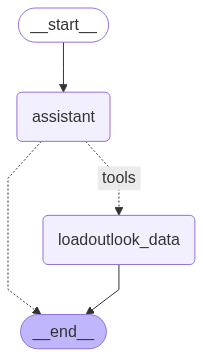

In [85]:
#Lets visualize the graph
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [87]:
#Now lets invoke this app

#invoking with a simple message
response=app.invoke({"messages": ["Hi, My Name is Yaseen Khan"]})
response

#Here we are getting the AI message from LLM (assistant) directly as this is simple query

{'messages': [HumanMessage(content='Hi, My Name is Yaseen Khan', additional_kwargs={}, response_metadata={}, id='3ed6f62f-dd28-46b5-88ac-c0daff0b9199'),
  AIMessage(content='Hello, Yaseen Khan! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 59, 'total_tokens': 74, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'id': 'chatcmpl-Bc8ik3a06cHSNGS2J3YADmz4YKBJI', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--c1355910-7880-40db-85c8-3b9b9a502607-0', usage_metadata={'input_tokens': 59, 'output_tokens': 15, 'total_tokens': 74, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [79]:
#Now lets invoke this app

#invoking with a simple message
response=app.invoke({"messages": ["please load the meeting data"]})
response

#Here we are getting the AI message from LLM (assistant) directly as this is simple query

{'messages': [HumanMessage(content='please load the meeting data', additional_kwargs={}, response_metadata={}, id='56afda14-ef87-4a2f-87a6-0507063064f0'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Wbunh3OndsXPaxG3KThYYXLa', 'function': {'arguments': '{}', 'name': 'load_meeting_data'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 55, 'total_tokens': 67, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'id': 'chatcmpl-BbvcoxrfVvpK5mg9ac07I4vMKFh1g', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f75fc3c7-892d-4231-a0f1-2e1a60d99c9e-0', tool_calls=[{'name': 'load_meeting_data', 'args': {}, 'id': 'call_Wbunh3OndsXPaxG3KThYYXL